## Load Imports

In [1]:
# python imports
from math import pi
import json
import os

# third-party imports
import pandas as pd
import numpy as np
import scipy.stats as st

from sklearn import preprocessing

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

## Load results

In [2]:
NETWORK_NAME = 'Network01'

In [3]:
cvss_stats = pd.DataFrame()
frape_stats = pd.DataFrame()
feature_importances = None
vulns = pd.DataFrame()

occurrences = 0

for file in os.listdir(f'../output/{NETWORK_NAME}/'):
    if file.endswith('.json'):
        with open(f'../output/{NETWORK_NAME}/{file}') as f:
            
            occurrences += 1
            
            json_file = json.load(f)
            
            # loading cvss and frape values
            
            iterations = json_file['iterations']
        
            cvss = pd.DataFrame.from_records(iterations['cvss_stats'])
            frape = pd.DataFrame.from_records(iterations['frape_stats'])
                       
            if not cvss_stats.empty:
                cvss_stats += cvss
                frape_stats += frape
            else:
                cvss_stats = cvss
                frape_stats = frape
            
            # loading feature importances
            
            features = pd.Series(json_file['feature_importances'])
                           
            if not feature_importances:
                feature_importances = {name: [] for name in features.index}
            
            for name, value in zip(features.index, features.values):
                feature_importances[name].append(value)
            
            # loading vulnerabilities to analysis
            
            vulns = pd.DataFrame.from_records(json_file['vulnerabilities'])

In [4]:
cvss_stats /= occurrences
frape_stats /= occurrences

feature_importances = pd.DataFrame(feature_importances, columns=feature_importances.keys())

feature_importances_std = feature_importances.std()
feature_importances = feature_importances.mean()

## Utils

In [5]:
def plot_graph_line(stats, columns, fill=False):
    
    labels = ['CVSS', 'FRAPE']
    lines = ['solid', 'solid']
    colors = ['#1f77b4', '#ff7f0e']
    hatches = ['////', '..']

    fig, axes = plt.subplots(1, len(columns), figsize=(12, 4), constrained_layout=True)
            
    for ax, column in zip(axes, columns):
        
        patches = list()
        
        for stat, label, ls, c, h in zip(stats, labels, lines, colors, hatches):

                y = stat[[column]].values
                y = np.squeeze(y).tolist()

                x = range(len(y))
                # x = [i * 2 for i in range(len(y))]

                ax.set_title(f'{column.upper()}')
                
                # https://towardsdatascience.com/how-to-calculate-confidence-intervals-in-python-a8625a48e62b

                std = np.std(y) 
                dof = len(x) - 1 
                confidence = 0.95

                # calculated using Student’s t distribution
                z_score = np.abs(st.t.ppf((1 - confidence) / 2, dof))

                yerr = z_score * std / np.sqrt(len(x))

                if fill:
                    patch = mpatches.Patch(facecolor=c, alpha=0.25, hatch=h, label=label, edgecolor='#0c0c0c')
                    patches.append(patch)
                    
                    ax.plot(x, y, label=f'{label}', ls=ls)
                    ax.fill_between(x, y - yerr, y + yerr, hatch=h, alpha=0.25, edgecolor='#0c0c0c')
                else:
                    ax.errorbar(x, y, yerr=yerr, label=f'{label}-{column}', ls=ls, capsize=2)
                    
                ax.legend(handles=patches)
                ax.grid(True, linestyle='--', alpha=.25)                
    
    fig.supxlabel('Percentage of Vulnerabilities Fixed (%)')
    fig.supylabel('Feature Aggregated Value')
    
    plt.show()

## Running

In [6]:
feature_importances = feature_importances[cvss_stats.columns]

feature_importances.drop(
    labels=['cve_published_date', 'exploit_published_date', 'epss',  'attack_type_none', 'vendor_other'], inplace=True)

feature_importances = feature_importances.sort_values(ascending=False).head(12)
feature_importance_names = feature_importances.index.tolist()

std_values = feature_importances_std[feature_importance_names].values

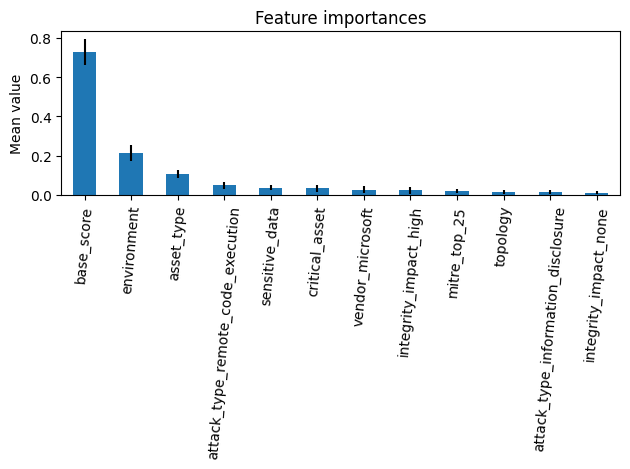

In [7]:
fig, ax = plt.subplots()

feature_importances.plot.bar(yerr=std_values, ax=ax)

ax.set_title("Feature importances")
ax.set_ylabel("Mean value")

ax.set_xticklabels(feature_importance_names, rotation=85)

fig.tight_layout()

In [8]:
cvss_stats = cvss_stats[feature_importance_names]
frape_stats = frape_stats[feature_importance_names]

stats = [cvss_stats, frape_stats]
n = len(feature_importance_names)

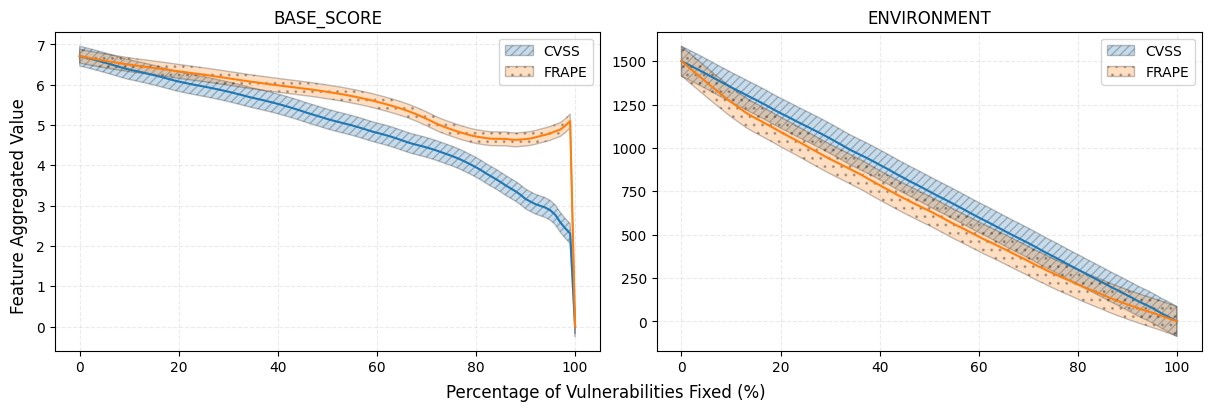

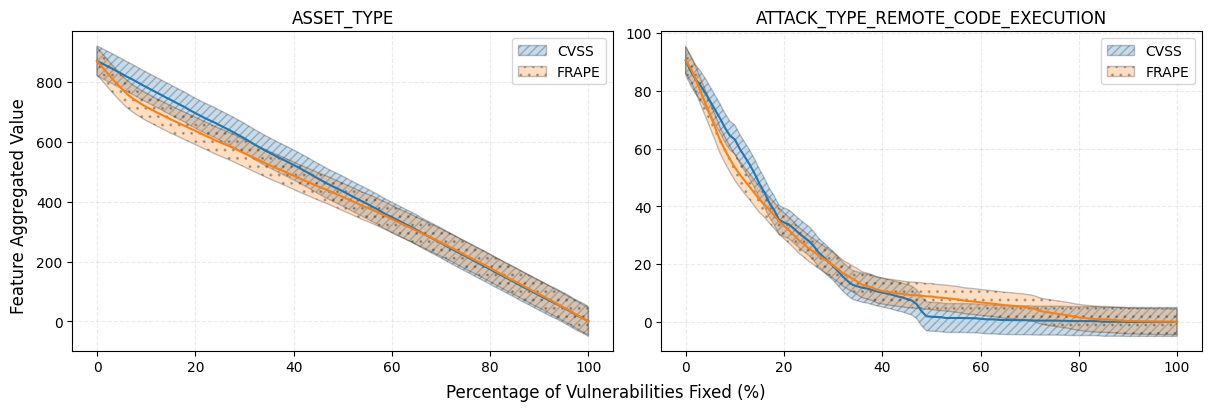

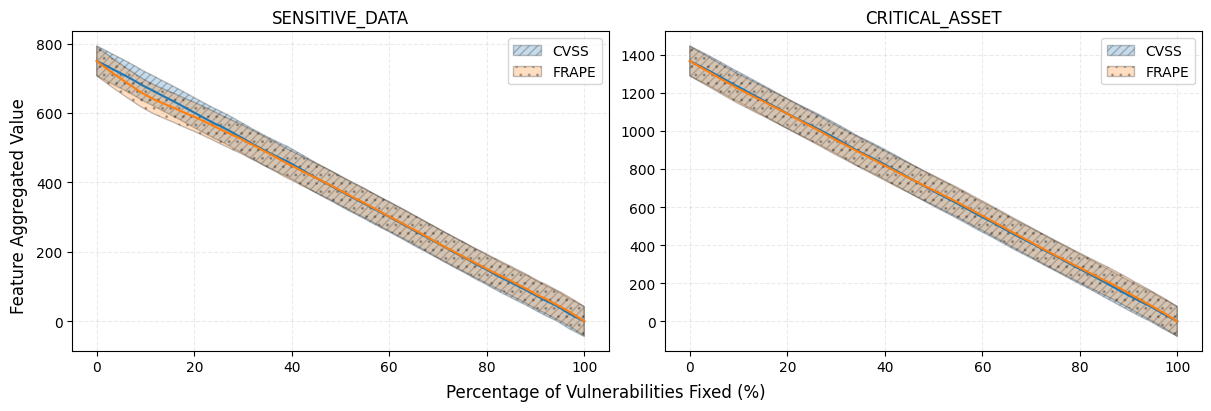

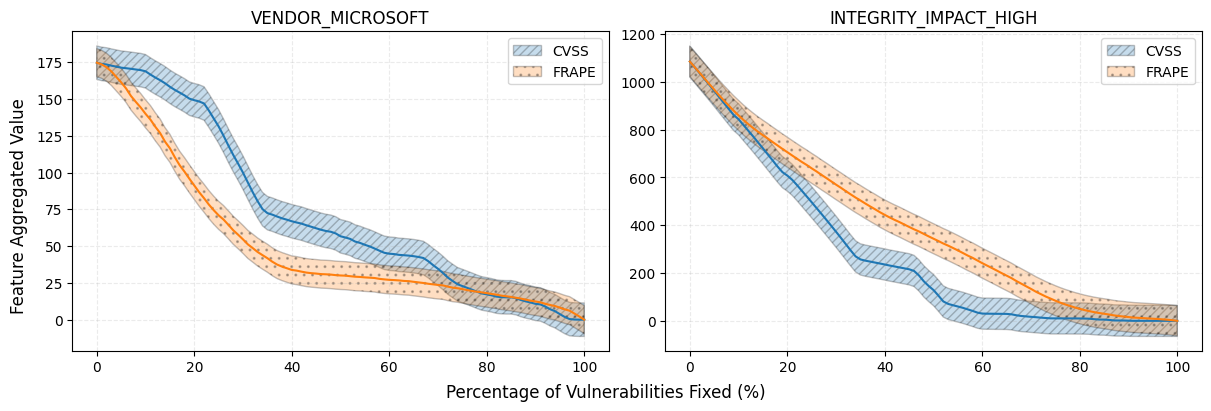

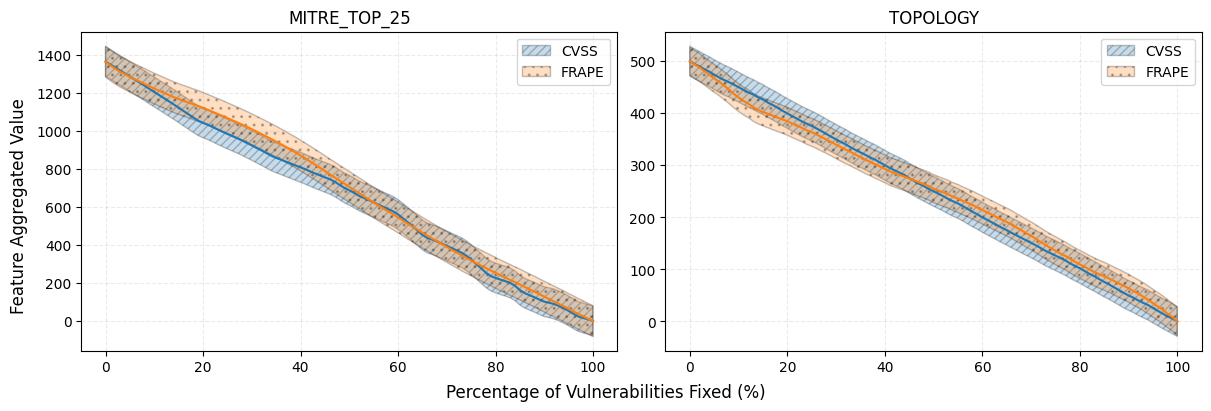

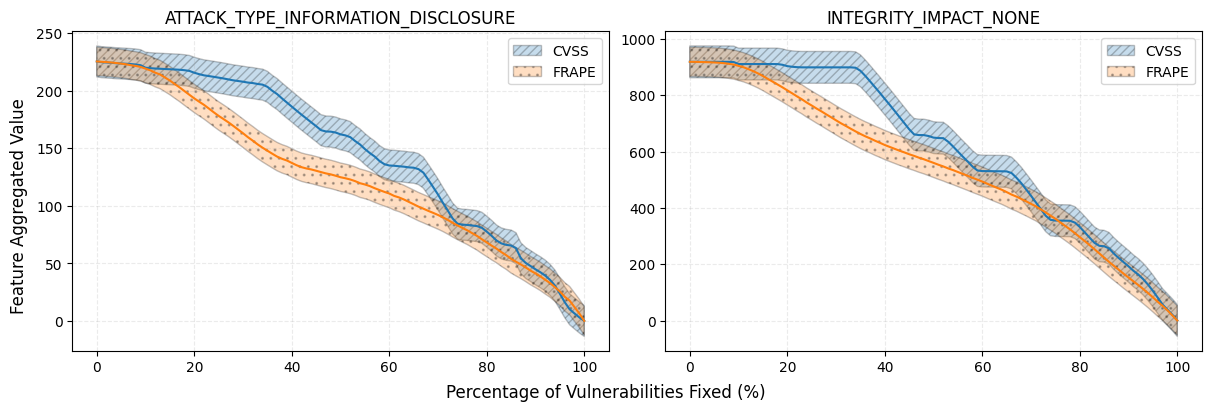

In [9]:
for index in range(0, n, 2):
    plot_graph_line(stats, feature_importance_names[index:index + 2], fill=True)